# Recommendation Systems Assignment

### MIE451/1513 UofT

### Getting MovieLens data

* Download the movielens 100k dataset from this link: [ml-100k.zip](http://files.grouplens.org/datasets/movielens/ml-100k.zip)

* Upload ml-100k.zip

* Extract using the following cell:

### Imports

In [0]:
# import required libraries
!pip install wget
import os
import os.path
import numpy as np
import pandas as pd
from math import sqrt
from heapq import nlargest
from tqdm import trange
from tqdm import tqdm
from scipy import stats
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import wget
import matplotlib.pyplot as plt

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9681 sha256=b1f76b6a5aa28bdaef59a422046c981417a1bba9a8fa72b770be778c78404a66
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


## Support functions and variables

In [0]:
wget.download("https://github.com/MIE451-1513-2019/course-datasets/raw/master/ml-100k.zip")
!unzip ml-100k.zip
MOVIELENS_DIR = "ml-100k"

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
!ls {MOVIELENS_DIR}

allbut.pl  u1.base  u2.test  u4.base  u5.test  ub.base	u.genre  u.occupation
mku.sh	   u1.test  u3.base  u4.test  ua.base  ub.test	u.info	 u.user
README	   u2.base  u3.test  u5.base  ua.test  u.data	u.item


In [0]:
def getData(folder_path, file_name):
    fields = ['userID', 'itemID', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(folder_path, file_name), sep='\t', names=fields)
    return data 

In [0]:
rating_df = getData(MOVIELENS_DIR, 'u.data')

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
num_users = len(rating_df.userID.unique())
num_items = len(rating_df.itemID.unique())
print("Number of users:", num_users)
print("Number of items:", num_items)

Number of users: 943
Number of items: 1682


## Q1

### (a)

In [0]:
def dataPreprocessor(rating_df, num_users, num_items):
      #This function takes the data frame, total number of users, total number of items 
      #and it should output a user-item matrix

    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
            
        NOTE 1: see where something very similar is done in the lab in function 'buildUserItemMatrix'    
            
        NOTE 2: data can have more columns, but your function should ignore 
              additional columns.
    """
    ########### your code goes here ###########
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((num_users, num_items), dtype=np.int8)#created an array that is 943*1628 and filled with zeros
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID-1, itemID-1] = rating
    
    ###########         end         ###########
    return matrix

In [0]:
dataPreprocessor(rating_df, num_users, num_items)

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

### (b)

In [0]:
class BaseLineRecSys(object):
    def __init__(self, method, processor=dataPreprocessor):
        """
            method: string. From ['popularity','useraverage']
            processor: function name. dataPreprocessor by default
        """
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.method_name
        
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'popularity': self.popularity,
            'useraverage': self.useraverage,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def useraverage(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByUserAverage'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
        for (user,item), rating in np.ndenumerate(train_matrix):
                # select the row for user
            userVector = train_matrix[user, :]
            
                # Extract the items the user already rated
            ratedItems = userVector[userVector.nonzero()]
            
                # If not empty, calculate average and set as rating for the current item
            if ratedItems.size == 0:
                itemAvg = 0
            else:
                itemAvg = ratedItems.mean()
            predictionMatrix[user, item] = itemAvg
            
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,))

        ###########         end         ###########
        
        return predictionMatrix
    
    @staticmethod
    def popularity(train_matrix, num_users, num_items):
        """
            INPUT:
                train_matrix: 2D numpy array.
                num_users: int. Number of Users.
                num_items: int. Number of Items.
            OUTPUT:
                predictionMatrix: 2D numpy array.
                
            NOTE: see where something very similar is done in the lab in function 'predictByPopularity'    
        """
        
        predictionMatrix = np.zeros((num_users, num_items))
        
        ########### your code goes here ###########
        # Initialize the predicted rating matrix with zeros
       # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
        # For every item calculate the number of people liked (4-5) divided by the number of people that rated
        itemPopularity = np.zeros((num_items))
        for item in range (num_items):
            numOfUsersRated = len(train_matrix[:, item].nonzero()[0])
            numOfUsersLiked = len(vf(train_matrix[:, item]).nonzero()[0])
            if numOfUsersRated == 0:
                itemPopularity[item] = 0
            else:
                itemPopularity[item] = numOfUsersLiked/numOfUsersRated
    
        for (user,item), rating in np.ndenumerate(train_matrix):
            predictionMatrix[user, item] = itemPopularity[item]
            
            # report progress every 100 users
            if (user % 100 == 0 and item == 1):
                print ("calculated %d users" % (user,)) 
    
                
        ###########         end         ###########
        return predictionMatrix    
    
    def predict_all(self, train_df, num_users, num_items):
        
        train_matrix = self.processor(train_df, num_users, num_items)
        self.__model = self.method(train_matrix, num_users, num_items)
        
    def evaluate_test(self, test_df, copy=False):
        
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
            
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]

        return prediction
        
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You don not have model..")
            

In [0]:
popularity_recsys = BaseLineRecSys('popularity')

In [0]:
popularity_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
x = popularity_recsys.getModel()

In [0]:
np.all(x<=1)

True

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
popularity_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:27, 1143.48it/s]


,userID,itemID,rating,timestamp,popularity
0,196,242,3,881250949,0.760684
1,186,302,3,891717742,0.804714
2,22,377,1,878887116,0.076923
3,244,51,2,880606923,0.555556
4,166,346,1,886397596,0.611111


In [0]:
average_user_rating_recsys = BaseLineRecSys('useraverage')

In [0]:
average_user_rating_recsys.predict_all(rating_df, num_users, num_items)

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


In [0]:
average_user_rating_recsys.getModel()

array([[3.61029412, 3.61029412, 3.61029412, ..., 3.61029412, 3.61029412,
        3.61029412],
       [3.70967742, 3.70967742, 3.70967742, ..., 3.70967742, 3.70967742,
        3.70967742],
       [2.7962963 , 2.7962963 , 2.7962963 , ..., 2.7962963 , 2.7962963 ,
        2.7962963 ],
       ...,
       [4.04545455, 4.04545455, 4.04545455, ..., 4.04545455, 4.04545455,
        4.04545455],
       [4.26582278, 4.26582278, 4.26582278, ..., 4.26582278, 4.26582278,
        4.26582278],
       [3.41071429, 3.41071429, 3.41071429, ..., 3.41071429, 3.41071429,
        3.41071429]])

In [0]:
average_user_rating_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:26, 1151.11it/s]


,userID,itemID,rating,timestamp,useraverage
0,196,242,3,881250949,3.615385
1,186,302,3,891717742,3.413043
2,22,377,1,878887116,3.351562
3,244,51,2,880606923,3.651261
4,166,346,1,886397596,3.550000


## Q2

### (a)

In [0]:
class SimBasedRecSys(object):

    def __init__(self, base, method, processor=dataPreprocessor):
        """
            base: string. From ['user', 'item']. User-based Similarity or Item-based
            method: string. From ['cosine', 'euclidean', 'somethingelse']
            processor: function name. dataPreprocessor by default
        """
        self.base = base
        self.method_name = method
        self.method = self._getMethod(self.method_name)
        self.processor = processor
        self.pred_column_name = self.base+'-'+self.method_name
    
    def _getMethod(self, method_name):
        """
            Don't change this
        """
        switcher = {
            'cosine': self.cosine,
            'euclidean': self.euclidean,
            'somethingelse': self.somethingelse,
        }
        
        return switcher[method_name]
    
    @staticmethod
    def cosine(matrix):
        """
            cosine similarity
        """
        similarity_matrix = 1 - pairwise_distances(matrix, metric='cosine')
        return similarity_matrix
    
    @staticmethod
    def euclidean(matrix):
        """
            euclidean similarity
        """
        ########### your code goes here ###########
        
        
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='euclidean'))
        
    
        ###########         end         ###########    
        
        return similarity_matrix
    
    @staticmethod
    def somethingelse(matrix):
        """
            manhattan? or super-natural intuition similarity
        """
        ########### your code goes here ###########
    
    
        similarity_matrix = 1/(1 + pairwise_distances(matrix, metric='manhattan'))
    
    
        ###########         end         ###########        
        return similarity_matrix
        
    def predict_all(self, train_df, num_users, num_items):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_row: scalar. number of users
                num_col: scalar. number of items
            OUTPUT:
                no return... this method assigns the result to self.model
            
            NOTES:
                self.__model should contain predictions for *all* user and items
                (don't worry about predicting for observed (user,item) pairs,
                 since we won't be using these predictions in the evaluation)
                (see code in for an efficient vectorized example)
        """
        train_matrix = self.processor(train_df, num_users, num_items)
        
        if self.base == 'user':
            ########### your code goes here ###########
            # Initialize the predicted rating matrix with zeros
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            uu_similarity = 1 - pairwise_distances(train_matrix, metric='cosine')
            # UxI: UxU mul UxI
            normalizer = np.matmul(uu_similarity, temp_matrix)
            #print(normalizer)
            normalizer[normalizer == 0] = 1e-5
            #what's the dimension of np.matmul(uu_similarity, trainSet)
            predictionMatrix = np.matmul(uu_similarity, train_matrix)/normalizer
            #predictionMatrix[temp_matrix.nonzero()] = 0
            #Cold start
            useraverage = np.sum(train_matrix, axis=1)/np.sum(temp_matrix, axis=1)
            columns = np.sum(predictionMatrix, axis=0)
            #print(columns.shape)
            predictionMatrix[:, columns==0] = predictionMatrix[:, columns==0] + np.expand_dims(useraverage, axis=1)
            self.__model = predictionMatrix
            ###########         end         ###########
            
        elif self.base == 'item':
            ########### your code goes here ###########
            """
            train_matrix_Trans = train_matrix.transpose()
            temp_matrix = np.zeros(train_matrix_Trans.shape)
            temp_matrix[train_matrix_Trans.nonzero()] = 1
            
            #change the matrix into item-user
            
            ii_similarity = self.method (train_matrix_Trans)
            normalizer = np.matmul(ii_similarity,temp_matrix)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(ii_similarity, train_matrix_Trans)/normalizer
            
            
            itemaverage = np.sum(train_matrix_Trans, axis = 1)/(np.sum(temp_matrix, axis=1)+1e-5)
            columns = np.sum(predictionMatrix, axis = 0)
            predictionMatrix[:, columns==0] = predictionMatrix[:,columns==0] + np.expand_dims(itemaverage, axis=1)
            self.__model = predictionMatrix.transpose()
            """
            temp_matrix = np.zeros(train_matrix.shape)
            temp_matrix[train_matrix.nonzero()] = 1
            train_matrix_Trans = np.transpose(train_matrix)
            ii_similarity = self.method (train_matrix_Trans)
            normalizer = np.matmul(temp_matrix,ii_similarity)
            normalizer[normalizer == 0] = 1e-5
            predictionMatrix = np.matmul(train_matrix, ii_similarity)/normalizer
            np.sum(temp_matrix,axis=0)[np.sum(temp_matrix,axis=0)==0]=1e-5
            itemaverage = np.sum(train_matrix_Trans, axis = 1)/np.sum(temp_matrix, axis=0)
            rows = np.sum(predictionMatrix, axis = 1)
            predictionMatrix[rows==0,:] = predictionMatrix[rows==0,:] + np.expand_dims(itemaverage, axis=0)
            self.__model = predictionMatrix
            ###########         end         ###########
        else:
            print('No other option available')
        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
            NOTE: 1. data can have more columns, but your function should ignore 
                  additional columns.
                  2. 'base-method' depends on your 'base' and 'method'. For example,
                  if base == 'user' and method == 'cosine', 
                  then base-method == 'user-cosine'
                  3. your predictions go to 'base-method' column
        """
        if copy:
            prediction = test_df.copy()
        else:
            prediction = test_df
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = self.__model[userID-1, itemID-1]
    
        return prediction
    
    def getModel(self):
        """
            return predicted user-item matrix
        """
        return self.__model
    
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.model = None
        except:
            print("You do not have model..")

In [0]:
# Examples of how to call similarity functions.
I = np.eye(3)
SimBasedRecSys.cosine(I)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [0]:
SimBasedRecSys.euclidean(I)

array([[1.        , 0.41421356, 0.41421356],
       [0.41421356, 1.        , 0.41421356],
       [0.41421356, 0.41421356, 1.        ]])

In [0]:
SimBasedRecSys.somethingelse(I)

array([[1.        , 0.33333333, 0.33333333],
       [0.33333333, 1.        , 0.33333333],
       [0.33333333, 0.33333333, 1.        ]])

(a)
Cosine similarity works best. Because it's a similarity metric that isn't concerned with the magnitude. Euclidein and Manhattan if we normalised will be affected by magnitude of vector.

### (b)

Manhattan metric is summing the absolute distance in different axes. It compares the results inside class, and then, it sums all the difference which makes more sense comparing with the euclidean matrix. That is why it can provide better results than euclidean. 

## Q3

### (a)

In [0]:
user_cosine_recsys = SimBasedRecSys('user','cosine')

In [0]:
user_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
user_cosine_recsys.getModel()

array([[3.89911175, 3.19022667, 3.0261129 , ..., 2.        , 3.        ,
        3.        ],
       [3.84034456, 3.17139889, 2.92626717, ..., 2.        , 3.        ,
        3.        ],
       [3.87104065, 3.12823798, 3.03250708, ..., 2.        , 3.        ,
        3.        ],
       ...,
       [3.90754645, 3.20227238, 3.05776201, ..., 2.        , 3.        ,
        3.        ],
       [3.91100649, 3.21591021, 2.98854017, ..., 2.        , 3.        ,
        3.        ],
       [3.91593122, 3.24268207, 3.08255897, ..., 0.        , 3.        ,
        3.        ]])

In [0]:
rating_df.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
user_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:41, 980.70it/s]


,userID,itemID,rating,timestamp,user-cosine
0,196,242,3,881250949,4.025213
1,186,302,3,891717742,4.142828
2,22,377,1,878887116,1.922080
3,244,51,2,880606923,3.431884
4,166,346,1,886397596,3.424963


In [0]:
item_cosine_recsys = SimBasedRecSys('item','cosine')
item_cosine_recsys.predict_all(rating_df, num_users, num_items)

In [0]:
item_cosine_recsys.getModel()

array([[3.75429099, 3.66419957, 3.73222997, ..., 3.60248287, 3.79662696,
        3.90232044],
       [3.83658867, 3.80424519, 3.77473905, ..., 3.72798332, 3.9109779 ,
        3.79775927],
       [2.84492718, 2.89389328, 2.84327324, ..., 2.99504451, 3.16444153,
        2.9858119 ],
       ...,
       [4.11427954, 4.0558267 , 4.00963139, ..., 4.        , 3.87872799,
        4.14814803],
       [4.37096823, 4.39679254, 4.33543016, ..., 3.955358  , 4.41891089,
        4.57995134],
       [3.52030345, 3.46948821, 3.52393064, ..., 0.        , 3.6110641 ,
        3.59656861]])

In [0]:
item_cosine_recsys.evaluate_test(rating_df,copy=True).head()

100000it [01:26, 1162.40it/s]


,userID,itemID,rating,timestamp,item-cosine
0,196,242,3,881250949,3.591314
1,186,302,3,891717742,3.344077
2,22,377,1,878887116,2.965365
3,244,51,2,880606923,3.637332
4,166,346,1,886397596,3.333013


### (b)

In [0]:
class CrossValidation(object):
    def __init__(self, metric, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.folds = self._getData(MOVIELENS_DIR)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            'P@K': self.patk,
            'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    # Precision at k
    def patk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items retrived
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
    
        # Initialize sum and count vars for average calculation
        sumPrecisions = 0
        countPrecisions = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Calculate precision
            precision = float(len([item for item in topK if item in userTestVector]))/len(topK)

            # Update sum and count
            sumPrecisions += precision
            countPrecisions += 1

        # Return average P@k
        return float(sumPrecisions)/countPrecisions
    
    # Recall at k
    def ratk(self, data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            k: top-k items relevant
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        prediction = self.getMatrix(data, num_users, num_items, pred)
        testSet =  self.getMatrix(data, num_users, num_items, true)
        # Initialize sum and count vars for average calculation
        sumRecalls = 0
        countRecalls = 0

        # Define function for converting 1-5 rating to 0/1 (like / don't like)
        vf = np.vectorize(lambda x: 1 if x >= 4 else 0)

        for userID in range(num_users):
            # Pick top K based on predicted rating
            userVector = prediction[userID,:]
            topK = nlargest(k, range(len(userVector)), userVector.take)

            # Convert test set ratings to like / don't like
            userTestVector = vf(testSet[userID,:]).nonzero()[0]

            # Ignore user if has no ratings in the test set
            if (len(userTestVector) == 0):
                continue

            # Calculate recall
            recall = float(len([item for item in topK if item in userTestVector]))/len(userTestVector)

            # Update sum and count
            sumRecalls += recall
            countRecalls += 1

        # Return average R@k
        return float(sumRecalls)/countRecalls
    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            test_set = getData(data_path, data_types[1].format(i))
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
# How to use CrossValidation Class?

In [0]:
# 1. gather your algorithms in previous steps.
#algorithm_instances = [popularity_recsys, 
                       #average_user_rating_recsys, 
                       #user_cosine_recsys]
algorithm_instances = [item_cosine_recsys, 
                       user_cosine_recsys]

In [0]:
# 2. Instantiate a CrossValidation instance and assign the measurement that you want to use
# RMSE, P@K, R@K
# Precision at K in this example
#cv_patk = CrossValidation('P@K')
cv_rmse = CrossValidation('RMSE')

In [0]:
# 3. Run CV by giving:
#    1> algorithms just gathered
#    2> number of users in the full dataset
#    3> number of items in the full dataset
#    4> precision or recall at K need a K value, so k=5 means precision at 5 in this example
# Results include independent results from 5 folds, their mean, and confidence interval.
#cv_patk.run(algorithm_instances, num_users, num_items,k=5)
cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2121.84it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2178.44it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2159.05it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2135.32it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2157.44it/s]


Processing algorithm user-cosine


20000it [00:09, 2152.76it/s]
20000it [00:09, 2164.86it/s]
20000it [00:09, 2135.87it/s]
20000it [00:09, 2182.30it/s]
20000it [00:09, 2161.78it/s]


{'item-cosine': [[1.0377631264364244,
   1.0207280585350078,
   1.0101820660011798,
   1.0136832839209695,
   1.0180579656376574],
  1.020082900106248,
  1.0068242686250732,
  1.0333415315874226],
 'user-cosine': [[1.026449013124381,
   1.0214387664779507,
   1.0132940326457187,
   1.0094003999022947,
   1.0161883961525586],
  1.0173541216605808,
  1.009013080226148,
  1.0256951630950135]}

Item-item cosine metric RMSE:1.020082900106248
confidence interval:[1.0068242686250732,1.0333415315874226]


---

User-user cosine metric RMSE:1.0173541216605808
confidence interval:[1.009013080226148,1.0256951630950135]


---

user user similarity based method has lower RMSE, in terms of RMSE result, user cosine is better than item item cosine method.

Because users cannot rate all movies, there must be some empty entries in user user matrix(cold start), average number of ratings per user is smaller than the number of ratings per item. Which causes lower mean and wider CI.

## Q4

### (a)

In [0]:
class PMFRecSys(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        """
            num_feat: int, number of latent features
            epsilon: float, learning rate
            _lambda: float, L2 regularization,
            momentum: float, momentum of the gradient,
            maxepoch: float, Number of epoch before stop,
            num_batches: int, Number of batches in each epoch (for SGD optimization),
            batch_size:Number int, of training samples used in each batches (for SGD optimization)
            
        """
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.maxepoch = maxepoch  # Number of epoch before stop,
        self.num_batches = num_batches  # Number of batches in each epoch (for SGD optimization),
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.test = False
        self.w_Item = None  # Item feature vectors
        self.w_User = None  # User feature vectors
        
        self.rmse_train = []
        self.rmse_test = []
        self.pred_column_name='PMF'

    def predict_all(self, train_vec, num_user, num_item):
        """
            INPUT: 
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
                num_user: scalar. number of users
                num_item: scalar. number of items
            OUTPUT:
                no return... this method update w_User and w_Item
            
            NOTES:
                self.W_Item and self.W_User are use to do the final predition for a user
                
        """
        # select 'userID', 'itemID', 'rating only
        train_vec = train_vec.iloc[:, :3].values
        if self.test:
          train_vec, val_vec = train_test_split(train_vec)
          pairs_val = val_vec.shape[0]
          self.mean_rating_test = np.mean(val_vec[:, 2])
        self.mean_rating_train = np.mean(train_vec[:, 2])  # avg rating
        pairs_train = train_vec.shape[0]  # num of rating
        

        # to avoid out of bound
        num_user += 1  
        num_item += 1  
        # initialize
        self.epoch = 0
        
        ########### your code goes here ###########
    
        #self.w_Item = None  # item M x D 
        #self.w_User = None  # user N x D 
        self.w_Item = 0.1 * np.random.randn(num_item, self.num_feat)
        self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)
        ###########         end         ###########  

        self.w_Item_inc = np.zeros((num_item, self.num_feat))  # accumulate the gradient
        self.w_User_inc = np.zeros((num_user, self.num_feat))  # accumulate the gradient
        while self.epoch < self.maxepoch: 
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  #shuffled

            # Batch update
            for batch in range(self.num_batches): 
                # print "epoch %d batch %d" % (self.epoch, batch+1)

                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  # get the real data index


                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_ItemID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Compute mean rating subtracted rating  
                ########### your code goes here ###########
            
                #pred_out = None #size (batch_size, )
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Item[batch_ItemID, :]),
                                  axis=1)
               
            
                ###########         end         ########### 

                rawErr = pred_out + self.mean_rating_train - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Item[batch_ItemID, :]) \
                       + self._lambda * self.w_User[batch_UserID, :]
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda * (self.w_Item[batch_ItemID, :])  # np.newaxis :increase the dimension

                dw_Item = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Item_inc = self.momentum * self.w_Item_inc + self.epsilon * dw_Item / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Item = self.w_Item - self.w_Item_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Compute mean rating subtracted rating 
                if batch == self.num_batches - 1:
                    train_user_idx = np.array(train_vec[:, 0], dtype='int32')
                    train_item_idx = np.array(train_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    #pred_out = None # size(pairs_train, )
                    pred_out = np.sum(np.multiply(self.w_User[train_user_idx, :],
                                                  self.w_Item[train_item_idx, :]),
                                      axis=1)
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_train - train_vec[:, 2] 
                    obj = np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda * (np.linalg.norm(self.w_User) ** 2 + np.linalg.norm(self.w_Item) ** 2)

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1 and self.test:
                    val_user_idx = np.array(val_vec[:, 0], dtype='int32')
                    val_item_idx = np.array(val_vec[:, 1], dtype='int32')
                    ########### your code goes here ###########
            
                    #pred_out = None #size(pairs_val, )
                    pred_out = np.sum(np.multiply(self.w_User[val_user_idx, :],
                                                  self.w_Item[val_item_idx, :]),
                                      axis=1) 
            
                    ###########         end         ########### 
                    rawErr = pred_out + self.mean_rating_test - val_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_val))


        

        
    def evaluate_test(self, test_df, copy=False):
        """
            INPUT:
                data: pandas DataFrame. columns=['userID', 'itemID', 'rating'...]
            OUTPUT:
                predictions:  pandas DataFrame. 
                              columns=['userID', 'itemID', 'rating', 'base-method'...]
                              
        """
        if copy:
            prediction = pd.DataFrame(test_df.copy(), columns=['userID', 'itemID', 'rating'])
        else:
            prediction = pd.DataFrame(test_df, columns=['userID', 'itemID', 'rating'])
        prediction[self.pred_column_name] = np.nan
        
        for (index, 
             userID, 
             itemID) in tqdm(prediction[['userID','itemID']].itertuples()):
            prediction.loc[index, self.pred_column_name] = (np.dot(self.w_Item, self.w_User[int(userID), :]) + self.mean_rating_train)[int(itemID)]
    
        return prediction
    
    def plot_error(self):
      if self.test:
        plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
      plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
      plt.title('The MovieLens Dataset Learning Curve')
      plt.xlabel('Number of Epochs')
      plt.ylabel('RMSE')
      plt.legend()
      plt.grid()
      plt.show()
          
    def getPredColName(self):
        """
            return prediction column name
        """
        return self.pred_column_name
    
    def reset(self):
        """
            reuse the instance of the class by removing model
        """
        try:
            self.w_Item = None 
            self.w_User = None 
        except:
            print("You do not have w_Item, w_User")

    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda = parameters.get("_lambda", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)
            self.test = parameters.get("test_mode", False)

In [0]:
pmf = PMFRecSys()
pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 20, "num_batches": 100,
                "batch_size": 1000, 'test_mode':False})#test lowest point

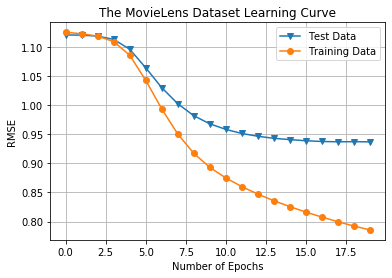

In [0]:
pmf.predict_all(rating_df, num_users, num_items)
pmf.plot_error()

## Q5

### (a)

In [0]:
algorithm_instances = [popularity_recsys, 
                       average_user_rating_recsys, 
                       user_cosine_recsys,
                       item_cosine_recsys,
                       pmf]


In [0]:
cv_patk = CrossValidation('P@K')
cv_ratk = CrossValidation('R@K')
cv_rmse = CrossValidation('RMSE')

In [0]:
patkresult = cv_patk.run(algorithm_instances, num_users, num_items,k=5)
ratkresult = cv_ratk.run(algorithm_instances, num_users, num_items,k=5)
rmsereslut = cv_rmse.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2149.59it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2196.85it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2176.68it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2125.99it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2148.13it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2210.69it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2218.52it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2195.69it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2202.48it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2201.67it/s]


Processing algorithm user-cosine


20000it [00:09, 2192.02it/s]
20000it [00:09, 2188.98it/s]
20000it [00:09, 2208.24it/s]
20000it [00:09, 2187.06it/s]
20000it [00:09, 2198.20it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2215.65it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2188.94it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2188.49it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2207.36it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2200.45it/s]


Processing algorithm PMF


20000it [00:16, 1181.06it/s]
20000it [00:15, 1256.45it/s]
20000it [00:15, 1260.73it/s]
20000it [00:16, 1249.42it/s]
20000it [00:16, 1248.24it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2202.79it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2216.94it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2194.11it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2176.73it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2200.30it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2192.45it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2218.42it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2199.49it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2198.24it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2171.20it/s]


Processing algorithm user-cosine


20000it [00:09, 2193.19it/s]
20000it [00:09, 2188.46it/s]
20000it [00:09, 2167.11it/s]
20000it [00:09, 2186.58it/s]
20000it [00:09, 2193.90it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2174.95it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2184.34it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2195.57it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2175.55it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2152.08it/s]


Processing algorithm PMF


20000it [00:15, 1252.84it/s]
20000it [00:15, 1253.48it/s]
20000it [00:16, 1237.82it/s]
20000it [00:15, 1257.52it/s]
20000it [00:16, 1234.81it/s]


Processing algorithm popularity
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2158.99it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2176.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2177.56it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2173.34it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users


0it [00:00, ?it/s]

calculated 800 users
calculated 900 users


20000it [00:09, 2117.88it/s]


Processing algorithm useraverage
calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2185.37it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2195.70it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2178.80it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2171.78it/s]


calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


20000it [00:09, 2175.76it/s]


Processing algorithm user-cosine


20000it [00:09, 2181.68it/s]
20000it [00:09, 2185.28it/s]
20000it [00:09, 2188.02it/s]
20000it [00:09, 2187.27it/s]
20000it [00:09, 2170.63it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2189.04it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2170.74it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2159.38it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2172.59it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
20000it [00:09, 2160.76it/s]


Processing algorithm PMF


20000it [00:16, 1235.77it/s]
20000it [00:16, 1215.66it/s]
20000it [00:16, 1223.53it/s]
20000it [00:15, 1259.07it/s]
20000it [00:16, 1242.06it/s]


In [0]:
print("P@k")
for recsys, val in patkresult.items():
    print("{recsys}\t{mean}".format(recsys=recsys, mean=val[1]))
print("\n")

print("R@k")
for recsys, val in ratkresult.items():
    print("{recsys}\t\t{mean}".format(recsys=recsys, mean=val[1]))
print("\n")   
    
print("rmse")
for recsys, val in rmsereslut.items():
    print("{recsys}\t\t{mean}".format(recsys=recsys, mean=val[1]))

P@k
popularity	0.5505832449628855
useraverage	0.4736373276776259
user-cosine	0.5558430540827157
item-cosine	0.5322163308589621
PMF	0.5467656415694601


R@k
popularity		0.4840758878843688
useraverage		0.44132320502242983
user-cosine		0.4862687235536437
item-cosine		0.4749711148590666
PMF		0.48044192964633475


rmse
popularity		3.1590928909890112
useraverage		1.0437176561595025
user-cosine		1.0173541216605808
item-cosine		1.020082900106248
PMF		0.9795884412222566


### (b)

RMSE cannot be used on popularity as popularity = # of likes/# of ratings(1-5). It is percentage value, so does not make sense to calculate popularity in probability.

(c) 

RMSE: PMF performs the best since it is the most personlized method. It should have smallest error.

P@K: user-cosine performs best since it has the largest percision rate comparing with the other methods. 

R@K: user-cosine performs best since it has the largest recall rate comparing with the other methods. 

Thus, overall user user cosine works best. This is because pmf and user cosine metrics are all user specified. It works well on perdict user's perference.





(d) Good RMSE implies good ranking, but not vice versa. Good performance on ranking does not necessarily mean perfect RMSE. 

This is because RMSE treats every element for same. Ranking focuses more on high-scoring items but RMSE treats equal emphasis on high and low ratings.

## Q6

### (a)

In [0]:
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [0]:
list_movie = moviesDF['movieTitle'].values.tolist()
list_movie#1682 movies in total

['Toy Story (1995)',
 'GoldenEye (1995)',
 'Four Rooms (1995)',
 'Get Shorty (1995)',
 'Copycat (1995)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Twelve Monkeys (1995)',
 'Babe (1995)',
 'Dead Man Walking (1995)',
 'Richard III (1995)',
 'Seven (Se7en) (1995)',
 'Usual Suspects, The (1995)',
 'Mighty Aphrodite (1995)',
 'Postino, Il (1994)',
 "Mr. Holland's Opus (1995)",
 'French Twist (Gazon maudit) (1995)',
 'From Dusk Till Dawn (1996)',
 'White Balloon, The (1995)',
 "Antonia's Line (1995)",
 'Angels and Insects (1995)',
 'Muppet Treasure Island (1996)',
 'Braveheart (1995)',
 'Taxi Driver (1976)',
 'Rumble in the Bronx (1995)',
 'Birdcage, The (1996)',
 'Brothers McMullen, The (1995)',
 'Bad Boys (1995)',
 'Apollo 13 (1995)',
 'Batman Forever (1995)',
 'Belle de jour (1967)',
 'Crimson Tide (1995)',
 'Crumb (1994)',
 'Desperado (1995)',
 'Doom Generation, The (1995)',
 'Free Willy 2: The Adventure Home (1995)',
 'Mad Love (1995)',
 'Nadja (1994)',
 'Net, The (1995

In [0]:
def recmovie (choosedmovie, DF, top = 5):
    result = {}
    movie_genre_matirx = DF.values[:,5:]
    movieSimilarity = item_cosine_recsys.getModel()
    movie_index = np.argsort(movieSimilarity, axis = 1)
    
    for k in choosedmovie:
      sim_movie = movie_index[k][-top:]
      movie = []
      print(list_movie[k])
      for i in sim_movie:
        movie.append(list_movie[i])
      
      result[k] = movie
      
    return result

In [0]:
choosedmovie = [111,123,321]

In [0]:
recmovie(choosedmovie, moviesDF)

Flipper (1996)
Lone Star (1996)
Murder at 1600 (1997)


{111: ['Here Comes Cookie (1935)',
  'Angel on My Shoulder (1946)',
  'Love Is All There Is (1996)',
  'Century (1993)',
  'The Deadly Cure (1996)'],
 123: ['Full Speed (1996)',
  'Rendezvous in Paris (Rendez-vous de Paris, Les) (1995)',
  'Visitors, The (Visiteurs, Les) (1993)',
  "Wooden Man's Bride, The (Wu Kui) (1994)",
  'Paris, France (1993)'],
 321: ['Hostile Intentions (1994)',
  'Hugo Pool (1997)',
  'Visitors, The (Visiteurs, Les) (1993)',
  'Little City (1998)',
  'Paris, France (1993)']}

### (b)

I picked Flipper (1996), Lone Star (1996), Murder at 1600 (1997).

The movie Flipper is a adventure film, the top 5 recommended movies are all action/adventure types. So these similarities are related to the picked movie type.

## Q7

### (a)

In [0]:
rating_per_user = rating_df.groupby('userID').count().reset_index()
rating_per_user.drop('itemID', axis = 1, inplace=True)
rating_per_user.drop('timestamp', axis = 1, inplace=True)

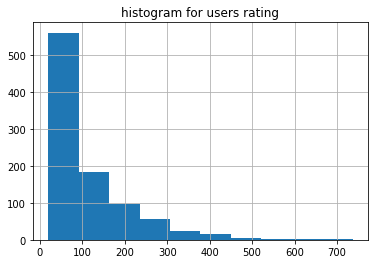

In [0]:
rating_per_user['rating'].hist()
plt.title("histogram for users rating")
plt.show()

In [0]:
#choose the threshold be median
median = np.median(rating_per_user['rating'])
median

65.0

In [0]:
useritemrating = dataPreprocessor(rating_df, num_users, num_items)
useritemrating

array([[5, 3, 4, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int8)

In [0]:
num_ratinguser = []
for i in range(useritemrating.shape[0]):
  num = np.count_nonzero(useritemrating[i])
  numm = num*[i]
  num_ratinguser.extend(numm)
  
  
histogram = np.histogram(num_ratinguser,bins=943)#lens = 2

In [0]:
def separate_bythreshold(Histogram,threshold):
  ID_above=[]
  ID_below=[]
  for i in range(Histogram[0].shape[0]):#943
    if Histogram[0][i]>threshold:
      ID_above.append(i)
    else:
      ID_below.append(i)
      
      
  above_df = rating_df[rating_df['userID'].isin(ID_above)]#Whether each element in the DataFrame is contained in values.
  below_df = rating_df[rating_df['userID'].isin(ID_below)]
  return above_df, below_df

In [0]:
above_df = separate_bythreshold(histogram, median)[0]
below_df = separate_bythreshold(histogram, median)[1]

In [0]:
#uu cosine above threshold
user_cosine_recsys_above = SimBasedRecSys('user','cosine')
user_cosine_recsys_above.predict_all(above_df, num_users, num_items)
user_cosine_recsys_above.getModel()

In [0]:
#uu cosine below threshold
user_cosine_recsys_below = SimBasedRecSys('user','cosine')
user_cosine_recsys_below.predict_all(below_df, num_users, num_items)
user_cosine_recsys_below.getModel()

In [0]:
#ii cosine above threshold
item_cosine_recsys_above = SimBasedRecSys('item','cosine')
item_cosine_recsys_above.predict_all(above_df,num_users,num_items)
item_cosine_recsys_above.getModel()

In [0]:
#ii cosine below threshold
item_cosine_recsys_below = SimBasedRecSys('item','cosine')
item_cosine_recsys_below.predict_all(below_df,num_users,num_items)
item_cosine_recsys_below.getModel()

In [0]:
class CrossValidation_threshold(object):
    def __init__(self, metric,datapt, data_path=MOVIELENS_DIR):
        """
            INPUT:
                metric: string. from['RMSE','P@K','R@K']
        """
        self.datapt = datapt
        self.folds = self._getData(MOVIELENS_DIR,self.datapt)
        self.metric_name = metric
        self.metric = self._getMetric(self.metric_name)
        
        
    def _getMetric(self, metric_name):
        """
            Don't change this
        """
        switcher = {
            'RMSE': self.rmse,
            #'P@K': self.patk,
            #'R@K': self.ratk,
        }
        
        return switcher[metric_name]
    
    @staticmethod
    def rmse(data, k, num_users, num_items, pred, true='rating'):
        """
            data: pandas DataFrame. 
            pred: string. Column name that corresponding to the prediction
            true: string. Column name that corresponding to the true rating
        """
        return sqrt(mean_squared_error(data[pred], data[true]))
    
    

    
    @staticmethod
    def getMatrix(rating_df, num_users, num_items, column_name):
        matrix = np.zeros((num_users, num_items))
    
        for (index, userID, itemID, value) in rating_df[['userID','itemID', column_name]].itertuples():
            matrix[userID-1, itemID-1] = value
            
        return matrix
    
    @staticmethod
    def _getData(data_path,datapt):
        """
            Don't change this function
        """
        folds = []
        data_types = ['u{0}.base','u{0}.test']
        for i in range(1,6):
            train_set = getData(data_path, data_types[0].format(i))
            
            if datapt=='above':
              train_set = train_set[train_set['userID'].isin(above_df['userID'])]
            else:
              train_set = train_set[train_set['userID'].isin(below_df['userID'])]
              
            test_set = getData(data_path, data_types[1].format(i))
            
            
            if datapt == 'above':
              test_set = test_set[test_set['userID'].isin(above_df['userID'])]
              
            else:
              test_set = test_set[test_set['userID'].isin(below_df['userID'])]
            folds.append([train_set, test_set])
        return folds
    
    def run(self, algorithms, num_users, num_items, k=1):
        """
            5-fold cross-validation
            algorithms: list. a list of algorithms. 
                        eg: [user_cosine_recsys, item_euclidean_recsys]
        """
        
        scores = {}
        for algorithm in algorithms:
            print('Processing algorithm {0}'.format(algorithm.getPredColName()))
            fold_scores = []
            for fold in self.folds:
                algorithm.reset()
                algorithm.predict_all(fold[0], num_users, num_items)
                prediction = algorithm.evaluate_test(fold[1])
                pred_col = algorithm.getPredColName()
                fold_scores.append(self.metric(prediction, k, num_users, num_items, pred_col))
                
            mean = np.mean(fold_scores)
            ci_low, ci_high = stats.t.interval(0.95, len(fold_scores)-1, loc=mean, scale=stats.sem(fold_scores))
            scores[algorithm.getPredColName()] = [fold_scores, mean, ci_low, ci_high]
            
        results = scores    
    
        return results
            

In [0]:
#RMSE above
algorithm_instances = [user_cosine_recsys_above,
                       item_cosine_recsys_above]

In [0]:
Q7_cv_rmse_above = CrossValidation_threshold('RMSE','above')
Q7_cv_rmse_above.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
10414it [00:04, 2213.07it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
10834it [00:04, 2202.43it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
10176it [00:04, 2219.13it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
9943it [00:04, 2229.79it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
9948it [00:04, 2218.74it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
10414it [00:04, 2212.98it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
10834it [00:04, 2229.07it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
10176it [00:04, 2260.08it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
9943it [00:04, 2272.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
9948it [00:04, 2248.64it/s]


{'item-cosine': [[1.0532113801789529,
   1.0325785971836228,
   1.027826531987525,
   1.0229485075247673,
   1.0378115398293226],
  1.0348753113408382,
  1.020421231804087,
  1.0493293908775894],
 'user-cosine': [[1.0310844968336732,
   1.0384685729954584,
   1.03213218110563,
   1.0274500853674566,
   1.0371444626994308],
  1.0332559598003297,
  1.0276348377518563,
  1.0388770818488031]}

In [0]:
#RMSE below
algorithm_instances = [user_cosine_recsys_below,
                       item_cosine_recsys_below]

In [0]:
Q7_cv_rmse_below = CrossValidation_threshold('RMSE','below')
Q7_cv_rmse_below.run(algorithm_instances, num_users, num_items,k=5)

Processing algorithm user-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
9586it [00:04, 2267.54it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
9166it [00:04, 2282.39it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
9824it [00:04, 2236.53it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
10010it [00:04, 2245.16it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
9931it [00:04, 2243.99it/s]


Processing algorithm item-cosine


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
9586it [00:04, 2266.26it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
9166it [00:03, 2300.95it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
9824it [00:04, 2247.11it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
10010it [00:04, 2230.37it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide
9931it [00:04, 2200.32it/s]


{'item-cosine': [[1.0420620795513655,
   1.0271788496354013,
   1.0145016001952452,
   1.0216452869463082,
   1.0198312538796797],
  1.0250438140416,
  1.011961500787947,
  1.038126127295253],
 'user-cosine': [[1.040569474423966,
   1.026381623525942,
   1.0169380243343538,
   1.0157678094815306,
   1.0114630325467848],
  1.0222239928625156,
  1.007806987579346,
  1.0366409981456852]}

I picked threshold = median(65.0);



*   The RMSE user user based method ABOVE threshold is: 1.0222239928625156
*   The RMSE user user based method BELOW threshold is: 1.0332559598003297


---



*   The RMSE item item based method ABOVE threshold is:1.0250438140416
*   The RMSE item item based method BELOW threshold is:1.0348753113408382





Above: The RMSE of user user cosine based method is lower than RMSE for item item based method, which represents better performance.

Below: The RMSE of user user cosine based method is lower than RMSE for item item based method, which represents better performance.



Thus, for each of user-user and item-item collaborative filtering, users with more ratings(above threshold) are better than the users with few number of ratings(below threshold). If the users have more ratings, the similarity preforms better.

# Validation

In [0]:
# Constants for validation only
ROW_NUM = 943
COL_NUM = 1682
RATING_COL = 'rating'

### dataPreprocessor

In [0]:
def validateDataPreprocessor(path=MOVIELENS_DIR, getData=getData, getMatrix=CrossValidation.getMatrix):
    validation_df = getData(MOVIELENS_DIR, 'u1.test')
    try:
        matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    except:
        print('dataPreprocessor function has error')
        return
    try:
        assert(matrix.shape == (ROW_NUM,COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape (943,1682)".format(matrix.shape)
    except Exception as e:
        print(e)
    return validation_df

In [0]:
validation_df = validateDataPreprocessor()

## Baseline Recommendation Systems

### Popularity Based Recommendation

In [0]:
def validatePopularityRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    popularity_recsys = BaseLineRecSys('popularity')
    try:
        popularity_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except Exception as e:        
        print('popularity function has error')
        print(e)
        return
    try:
        predictionMatrix = popularity_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


### User Average Based Recommendation

In [0]:
def validateUserAverRecSys(validation_df=validation_df, BaseLineRecSys = BaseLineRecSys):
    useraverage_recsys = BaseLineRecSys('useraverage')
    try:
        useraverage_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
    except:
        print('useraverage function has error')
        return
    try:
        predictionMatrix = useraverage_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validatePopularityRecSys()

calculated 0 users
calculated 100 users
calculated 200 users
calculated 300 users
calculated 400 users
calculated 500 users
calculated 600 users
calculated 700 users
calculated 800 users
calculated 900 users


## Similary Based Recommendation Systems

### Euclidean Similarity Function

In [0]:
def validateEuclidean(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.euclidean(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e)        

In [0]:
validateEuclidean()

### Customized Similarity Function (test somethingelse function)

In [0]:
def validateCustomizedSim(validation_df=validation_df, getMatrix=CrossValidation.getMatrix):
    matrix = getMatrix(validation_df, ROW_NUM, COL_NUM, RATING_COL)
    try:
        sim_matrix = SimBasedRecSys.somethingelse(matrix)
        assert(sim_matrix.shape == (ROW_NUM, ROW_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(sim_matrix.shape,ROW_NUM,ROW_NUM)
        assert(np.any(sim_matrix <= 1)),\
               "Exist similarity value that is not less or equal to 1."
    except Exception as e:
        print(e) 

In [0]:
validateCustomizedSim()

### User-User Similarity Based Recommendation System

In [0]:
def validateUUSimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('user','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateUUSimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


### Item-Item Similarity Based Recommendation System

In [0]:
def validateIISimBasedRecSys(validation_df=validation_df, dataPreprocessor=dataPreprocessor):
    try:
        user_cosine_recsys = SimBasedRecSys('item','cosine', dataPreprocessor)
    except:
        print("Got error when instantiate SimBasedRecSys")
        return
    
    try:
        user_cosine_recsys.predict_all(validation_df, ROW_NUM, COL_NUM)
        predictionMatrix = user_cosine_recsys.getModel()
        assert(predictionMatrix.shape == (ROW_NUM, COL_NUM)),\
        "Shape of matrix{0} doesn't match predefined shape ({1},{2})"\
        .format(predictionMatrix.shape,ROW_NUM, COL_NUM)
    except Exception as e:
        print(e)

In [0]:
validateIISimBasedRecSys()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:130: RuntimeWarning: invalid value encountered in true_divide


### Probabilistic Matrix Factorization Recommendation System

In [0]:
def validatePMFRecSys(validation_df=validation_df):
    try:
        pmf = PMFRecSys()
        pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda": 0.1, "momentum": 0.8, "maxepoch": 1, "num_batches": 100,
                "batch_size": 1000, 'test_mode':True})
        pmf.predict_all(rating_df, ROW_NUM, COL_NUM)
    except:
        print("Got error when instantiate PMFRecSys")
        return
    
    try:
        pmf.predict_all(validation_df, ROW_NUM, COL_NUM)
        W_item, W_user = pmf.w_Item, pmf.w_User
        assert(W_item.shape == (COL_NUM+1, 10) and W_user.shape == (ROW_NUM+1, 10)),\
        "Shape of w_Item and W_User doesn't match predefined shape"
    except Exception as e:
        print(e)

In [0]:
validatePMFRecSys(validation_df=validation_df)